# Elastic Net Regression

Elastic Net regression is a badass, probably because it is a dynamic ensemble of regularisation techniques. Often during a regression setup, merely LASSO (L1 penalty) or ridge (L2 penalty) does not seem to make it. Specially when the number of features in the data set, p >> n, the number of observations. Or maybe the variables are in the bad company of multicolinearity. In such a distress, Elastic Net can redeem you. The formula of Elastic Net is

  $ \hat{\beta} = \underset{\beta}{\operatorname{argmin}} [\sum_{i=1}^N (y-X \beta )^2 + \lambda\ P_\alpha(\beta)] $
  
  $P_\alpha(\beta) =  (1 - \alpha) \frac{1}{2} \| \Gamma \beta\|^2_{l_1} + \alpha \| \Gamma \beta\|_{l_2}$
  
where $\lambda$ is called the complexity parameter and $\alpha$ is the hyperparameter, if $\alpha$ = 0, it's completely ridge and $\alpha$ = 1 is completely LASSO. $\Gamma$ is the vector of penalty factors.

In order to demonstrate the implementation of Elastic Net, we choose a classification problem, although not too high dimensional, is fairly enough for our purpose.

We shall be utilizing the _glmnet_ package and be seeking help from _parallel_ and _doParallel_ packages in R programming language and environment 

In [56]:
suppressPackageStartupMessages({
    library(useful)
    library(glmnet)
    library(parallel)
    library(doParallel)
    library(foreach)
    library(reshape2)
    library(stringr)
})

### 'Adult' data set

This data set is downloaded from the UCI Machine Learning repository. *Prediction task is to determine whether a person makes over 50K a year*


In [82]:
adult <- read.table("E:/adult.data.csv", sep = ",", header = FALSE, stringsAsFactors = FALSE)

First, let's rename the columns as per convenience. The column names, however, are available from the UCI website.

In [91]:
names(adult) <- c('age','workclass','fnlwgt','education','education_num','marital_status','occupation','relationship','race','sex','capital_gain','capital_loss','hours_per_week','native_country','income')

Next, getting a first impression of the data, as we almost always do.

In [97]:
head(adult,100)

age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [88]:
str(adult)

'data.frame':	32561 obs. of  15 variables:
 $ age           : int  39 50 38 53 28 37 49 52 31 42 ...
 $ workclass     : chr  " State-gov" " Self-emp-not-inc" " Private" " Private" ...
 $ fnlwgt        : int  77516 83311 215646 234721 338409 284582 160187 209642 45781 159449 ...
 $ education     : chr  " Bachelors" " Bachelors" " HS-grad" " 11th" ...
 $ education-num : int  13 13 9 7 13 14 5 9 14 13 ...
 $ marital-status: chr  " Never-married" " Married-civ-spouse" " Divorced" " Married-civ-spouse" ...
 $ occupation    : chr  " Adm-clerical" " Exec-managerial" " Handlers-cleaners" " Handlers-cleaners" ...
 $ relationship  : chr  " Not-in-family" " Husband" " Not-in-family" " Husband" ...
 $ race          : chr  " White" " White" " White" " Black" ...
 $ sex           : chr  " Male" " Male" " Male" " Male" ...
 $ capital-gain  : int  2174 0 0 0 0 0 0 0 14084 5178 ...
 $ capital-loss  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ hours-per-week: int  40 13 40 40 40 40 16 45 50 40 ...
 $ native-countr

In [86]:
summary(adult)

      age         workclass             fnlwgt         education        
 Min.   :17.00   Length:32561       Min.   :  12285   Length:32561      
 1st Qu.:28.00   Class :character   1st Qu.: 117827   Class :character  
 Median :37.00   Mode  :character   Median : 178356   Mode  :character  
 Mean   :38.58                      Mean   : 189778                     
 3rd Qu.:48.00                      3rd Qu.: 237051                     
 Max.   :90.00                      Max.   :1484705                     
 education-num   marital-status      occupation        relationship      
 Min.   : 1.00   Length:32561       Length:32561       Length:32561      
 1st Qu.: 9.00   Class :character   Class :character   Class :character  
 Median :10.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :10.08                                                           
 3rd Qu.:12.00                                                           
 Max.   :16.00                               

In [89]:
dim(adult)

[1] 32561    15

### Anomaly detection and treatment

In [171]:
counter_na <- colSums(is.na(adult))
counter_na

age      workclass         fnlwgt      education  education_num 
             0              0              0              0              0 
marital_status     occupation   relationship           race            sex 
             0              0              0              0              0 
  capital_gain   capital_loss hours_per_week native_country         income 
             0              0              0              0              0

Bravo! No missing values. Careful, we need one more layer of screening.

In [87]:
apply(adult, 2, unique)

$age
 [1] "39" "50" "38" "53" "28" "37" "49" "52" "31" "42" "30" "23" "32" "40" "34"
[16] "25" "43" "54" "35" "59" "56" "19" "20" "45" "22" "48" "21" "24" "57" "44"
[31] "41" "29" "18" "47" "46" "36" "79" "27" "67" "33" "76" "17" "55" "61" "70"
[46] "64" "71" "68" "66" "51" "58" "26" "60" "90" "75" "65" "77" "62" "63" "80"
[61] "72" "74" "69" "73" "81" "78" "88" "82" "83" "84" "85" "86" "87"

$workclass
[1] " State-gov"        " Self-emp-not-inc" " Private"         
[4] " Federal-gov"      " Local-gov"        " ?"               
[7] " Self-emp-inc"     " Without-pay"      " Never-worked"    

$fnlwgt
    [1] "  77516" "  83311" " 215646" " 234721" " 338409" " 284582" " 160187"
    [8] " 209642" "  45781" " 159449" " 280464" " 141297" " 122272" " 205019"
   [15] " 121772" " 245487" " 176756" " 186824" "  28887" " 292175" " 193524"
   [22] " 302146" "  76845" " 117037" " 109015" " 216851" " 168294" " 180211"
   [29] " 367260" " 193366" " 190709" " 266015" " 386940" "  59951" " 311512"
   [36] " 242406" " 197200" " 544091" "  84154" " 265477" " 507875" "  88506"
   [43] " 172987" "  94638" " 289980" " 337895" " 144361" " 128354" " 101603"
   [50] " 271466" "  32275" " 226956" "  51835" " 251585" " 109832" " 237993"
   [57] " 216666" "  56352" " 147372" " 188146" "  59496" " 293936" " 149640"
   [64] " 116632" " 105598" " 155537" " 183175" " 169846" " 191681" " 200681"
   [71] " 101509" " 309974" " 162298" " 211678" " 124744" " 213921" "  32214"
   [78] " 212759" " 309634" " 125927" " 446839" " 276515" "  51618" " 159937"
   [85] " 343591" " 346253" " 268234" " 202051" "  54334" " 410867" " 249977"
   [92] " 286730" " 212563" " 117747" " 226296" " 115585" " 191277" " 202683"
   [99] " 171095" " 249409" " 124191" " 198282" " 149116" " 188300" " 103432"
  [106] " 317660" " 304873" " 194901" " 189265" " 124692" " 432376" "  65324"
  [113] " 335605" " 377869" " 102864" "  95647" " 303090" " 197371" " 247552"
  [120] " 102632" " 199915" " 118853" "  77143" " 267989" " 301606" " 287828"
  [127] " 111697" " 114937" " 129305" " 365739" "  69621" "  43323" " 120985"
  [134] " 254202" " 146195" " 125933" "  56920" " 163127" "  34310" "  81973"
  [141] "  66614" " 232782" " 316868" " 196584" " 105376" " 185814" " 175374"
  [148] " 108293" " 181232" " 174662" " 186009" " 198183" " 163003" " 296158"
  [155] " 252903" " 187715" " 214542" " 494223" " 191535" " 228456" "  38317"
  [162] " 252752" "  78374" "  88419" " 201080" " 207157" " 235485" " 102628"
  [169] "  25828" "  54826" " 124953" " 175325" "  96062" " 428030" " 149624"
  [176] " 253814" " 312956" " 483777" " 183930" "  37274" " 181344" " 114580"
  [183] " 633742" " 286370" "  29054" " 304030" " 143129" " 135105" "  99928"
  [190] " 109567" " 155222" " 159567" " 523910" " 120939" " 130760" " 197387"
  [197] "  99374" "  56795" " 138992" "  32921" " 397317" " 170653" " 259323"
  [204] " 254817" "  48211" " 140164" " 128757" "  36270" " 210563" "  65368"
  [211] " 160943" " 208358" " 153790" "  85815" " 125417" " 635913" " 313321"
  [218] " 182609" " 109434" " 255004" " 197860" " 187656" "  51744" " 176681"
  [225] " 140359" " 243313" "  24215" " 167687" " 314209" " 176796" " 538583"
  [232] " 130408" " 159732" " 110978" "  76714" " 268700" " 170525" " 180138"
  [239] " 115076" " 115458" " 347890" " 196001" " 273905" " 119156" " 179488"
  [246] " 203580" " 236596" " 183916" " 207578" " 153141" " 112763" " 390781"
  [253] " 171328" "  27382" " 259014" " 303044" " 117789" " 172579" " 187666"
  [260] " 204518" " 150042" "  98092" " 245918" " 146013" " 378322" " 257295"
  [267] " 218956" "  21174" " 185480" " 222205" "  69867" " 191260" "  30653"
  [274] " 209109" "  70377" " 477983" " 170924" " 190174" " 193787" " 279472"
  [281] "  34918" "  97688" " 175413" " 173960" " 205759" " 425161" " 220531"
  [288] " 176609" " 371987" " 193884" " 200352" " 127595" " 220419" " 231931"
  [295] " 248402" " 111095" "  57424" " 157443" " 278130" " 169469" " 146268"
  [302] " 153718" " 217460" " 238638" 

Some of the features contain missing observations in form of ' ?'. We assume, in the present context, the ' ?''s are MCAR and exclude them from analysis. Alright, need to subset observations with complete cases.

In [108]:
adult <- adult[adult$workclass != " ?" & adult$occupation != " ?" & adult$native_country != " ?",]

In [172]:
dim(adult)

[1] 30162    15

We could have spent much more time dealing with feature engineering and data manipulation works (Goshh! Some variables do look thirsty for such treatments!). But let's save it for some other day, please.
Next, make a binary variable 'income' for building a logistic regression.

In [115]:
adult$income <- with(adult, adult$income == " <=50K")

_glmnet_ in general needs a predictor matrix. The _build.x_ function from _useful_ package creates nice predictor matrices.

In [117]:
adultX <- build.x(income ~ age + workclass + fnlwgt + education + education_num + marital_status + occupation + 
                relationship + race + sex + capital_gain + capital_loss + hours_per_week + native_country - 1, data=adult, contrasts = FALSE)

In [118]:
class(adultX);dim(adultX)

[1] "matrix"

[1] 30162   104

In [119]:
adultY <- build.y(income ~ age + workclass + fnlwgt + education + education_num + marital_status + occupation + 
                relationship + race + sex + capital_gain + capital_loss + hours_per_week + native_country - 1, data=adult)

In [120]:
set.seed(21364597)

cv.glmnet tells us which value of	λ minimizes	the	cross-validation	error.	Additionally,	it	also	returns	the	largest	value	of	λ with	a	cross-validation	error	that	is	within	one	standard	error	of	the	minimum. Occam's Razor (Principle of Parsimony) suggests that the simpler model, even though it	is	slightly less accurate,	should	be preferred.

In [121]:
adultCV1 <- cv.glmnet(x=adultX, y=adultY, family = "binomial", nfold=5)

In [122]:
adultCV1$lambda.min

[1] 0.0006606864

In [123]:
adultCV1$lambda.1se

[1] 0.004246941

The	cross-validation errors	for	differing values of	λ are shown in the plot below. The	top	row	of	numbers	indicates	how	many	variables	(factor	levels are	counted	as	individual	variables)	are	in	the	model	for	a	given	value	of	log(λ).	The dots	represent	the	cross-validation	error	at	that	point	and	the	vertical	lines	are	the confidence	interval	for	the	error.	The	leftmost	vertical	line	indicates	the	value	of	λ where	the	error	is	minimized	and	the	rightmost	vertical	line	is	the	next	largest	value	of λ	error	that	is	within	one	standard	error	of	the	minimum. 	

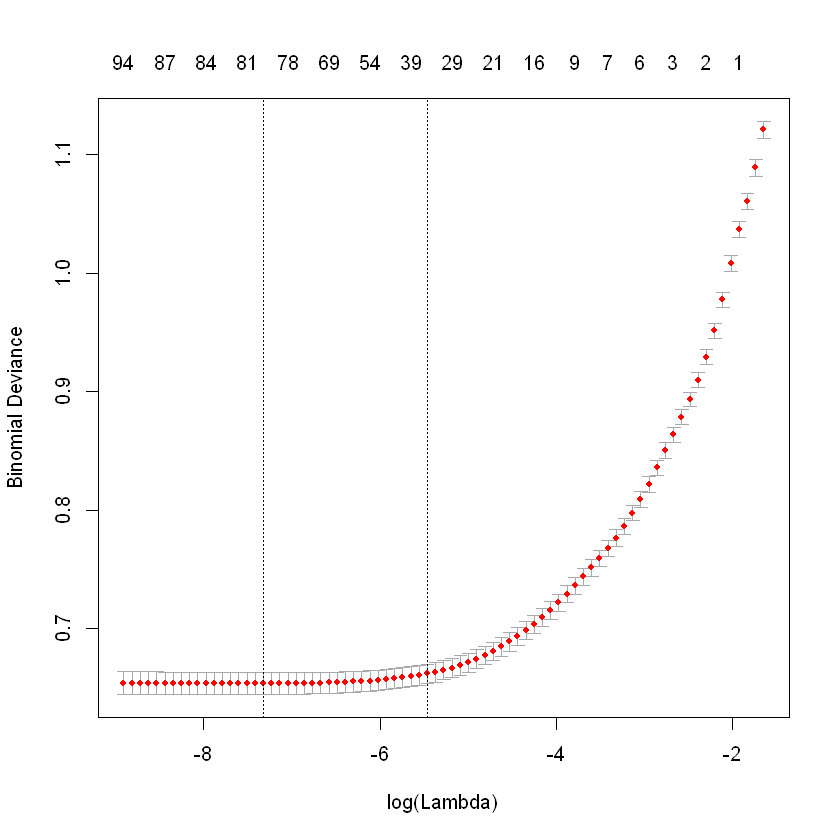

In [124]:
plot(adultCV1)

In [125]:
coef(adultCV1, s="lambda.1se")

105 x 1 sparse Matrix of class "dgCMatrix"
                                                      1
(Intercept)                                7.452203e+00
age                                       -2.284516e-02
workclass Federal-gov                     -3.725640e-01
workclass Local-gov                        .           
workclass Private                          .           
workclass Self-emp-inc                    -1.568324e-01
workclass Self-emp-not-inc                 2.937237e-01
workclass State-gov                        3.972143e-02
workclass Without-pay                      .           
fnlwgt                                    -2.670333e-07
education 10th                             .           
education 11th                             .           
education 12th                             .           
education 1st-4th                          .           
education 5th-6th                          .           
education 7th-8th                          .           
educa

Some levels of factor are selected and others are not because LASSO eliminates variables that are highly correlated with each other.

In the following plot, each	line	represents	a	coefficient’s	value	at	different	values	of	λ.	The	leftmost	vertical	line indicates	the	value	of	λ	where	the	error	is	minimized	and	the	rightmost	vertical	line	is	the	next	largest value	of	λ	error	that	is	within	one	standard	error	of	the	minimum

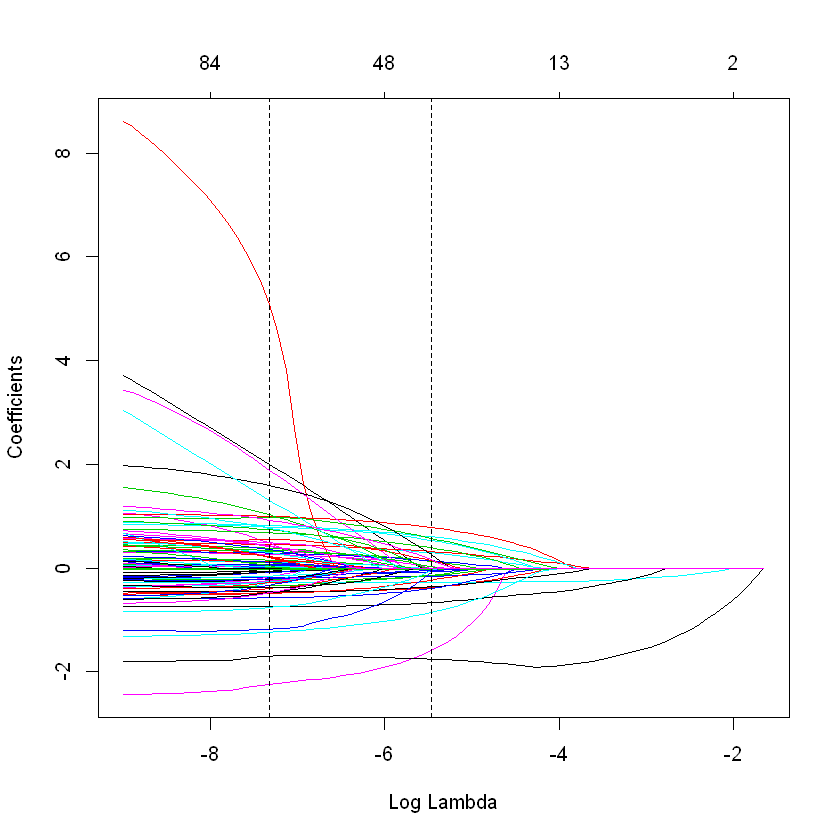

In [126]:
plot(adultCV1$glmnet.fit, xvar = "lambda")
abline(v=log(c(adultCV1$lambda.min, adultCV1$lambda.1se)), lty=2)

Setting	α	to	0	causes	the	regularisation to be completely	ridge.	In	this	case,	every	variable	is	kept	in	the	model but	is	just	shrunk	closer	to	0

In [127]:
set.seed(84756)

In [128]:
adultCV2 <- cv.glmnet(x=adultX, y=adultY, family="binomial", nfold=5, alpha=0)

In [129]:
adultCV2$lambda.min

[1] 0.02113712

In [130]:
adultCV2$lambda.1se

[1] 0.02545974

In [131]:
coef(adultCV2, s="lambda.1se")

105 x 1 sparse Matrix of class "dgCMatrix"
                                                      1
(Intercept)                                5.345928e+00
age                                       -2.061885e-02
workclass Federal-gov                     -4.865905e-01
workclass Local-gov                        6.749782e-02
workclass Private                         -5.027305e-02
workclass Self-emp-inc                    -3.128812e-01
workclass Self-emp-not-inc                 2.972907e-01
workclass State-gov                        1.815915e-01
workclass Without-pay                      1.645734e+00
fnlwgt                                    -5.461147e-07
education 10th                             4.892027e-01
education 11th                             4.652898e-01
education 12th                             3.171417e-01
education 1st-4th                          4.088599e-01
education 5th-6th                          4.549892e-01
education 7th-8th                          6.641192e-01
educa

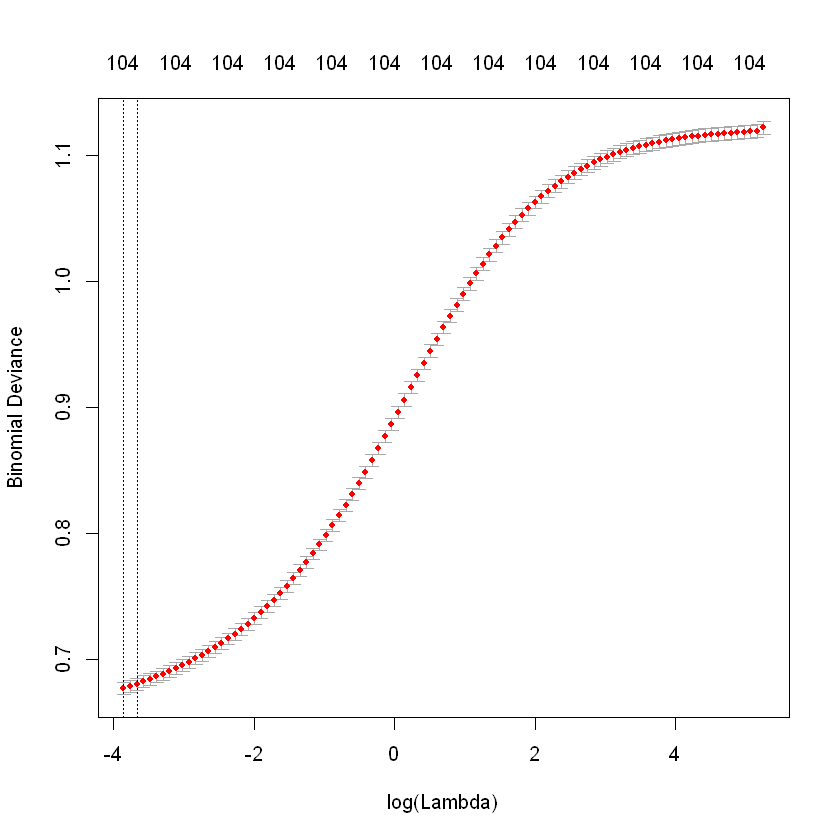

In [132]:
plot(adultCV2)

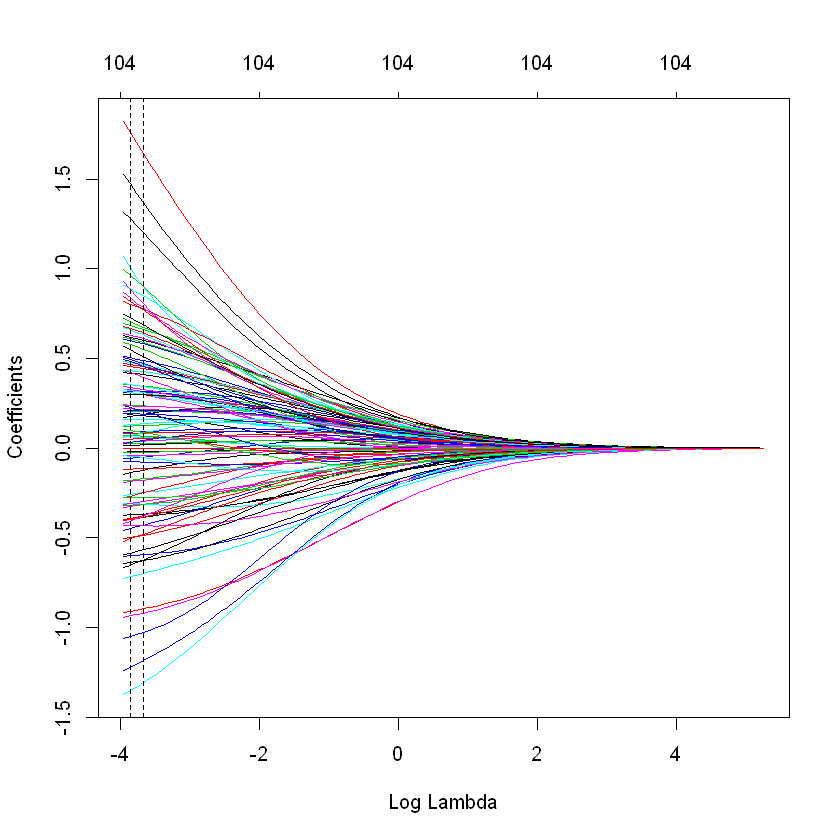

In [133]:
plot(adultCV2$glmnet.fit, xvar = "lambda")
abline(v=log(c(adultCV2$lambda.min, adultCV2$lambda.1se)), lty=2)

Next we find the optimal value of $\alpha$ with the help of _parallel_, _doParallel_ and _foreach_ package.

First a cluster is created and registered. Setting .errorhandling	to	"remove"	means	that	if	an	error	occurs,	that	iteration	will	be	skipped. Setting	.inorder	to	FALSE	means	that	the	order	of	combining	the	results	does	not	matter and	they	can	be	combined	whenever	returned,	which	yields	significant	speed	improvements. Because	we	are	using	the	default	combination	function,	list,	which	takes	multiple arguments	at	once,	we	can	speed	up	the	process	by	setting	.multicombine	to	TRUE.	We specify	in	.packages	that	glmnet	should	be	loaded	on	each	of	the	workers,	again	leading	to performance	improvements.	The	operator	%dopar%	tells	foreach	to	work	in	parallel.

In [134]:
set.seed(25364758)

In [135]:
theFolds <- sample(rep(x=1:5, length.out = nrow(adultX)))

In [136]:
alphas <- seq(from=.5, to=1, by=.05)

In [137]:
set.seed(5245175)

In [146]:
cl <- makeCluster(2)

In [147]:
registerDoParallel(cl)

In [148]:
before <- Sys.time()
adultDouble <- foreach(i=1:length(alphas), .errorhandling = "remove", .inorder = FALSE, .multicombine = TRUE,
            .export = c("adultX", "adultY", "alphas", "theFolds"), .packages = "glmnet" ) %dopar%
    {
        print(alphas[i])
        cv.glmnet(x=adultX, y=adultY, family="binomial", nfolds=5, foldid=theFolds, alpha=alphas[i])
    }
after <- Sys.time()
stopCluster(cl)

Warning message in e$fun(obj, substitute(ex), parent.frame(), e$data):
"already exporting variable(s): adultX, adultY, alphas, theFolds"

In [149]:
after - before

Time difference of 4.093597 mins

Next we use _ggplot_ to find the optimal value of $\alpha$ and $\lambda$ by plotting the errors

In [151]:
extractGlmnetInfo <- function(object) {
    
    lambdaMin <- object$lambda.min
    lambda1se <- object$lambda.1se
    
    whichMin <- which(object$lambda == lambdaMin)
    which1se <- which(object$lambda == lambda1se)
    
    data.frame(lambda.min=lambdaMin, error.min=object$cvm[whichMin],
              lambda.1se=lambda1se, error.1se=object$cvm[which1se])
}

In [152]:
alphaInfo <- Reduce(rbind, lapply(adultDouble, extractGlmnetInfo))

In [153]:
alphaInfo$Alpha <- alphas

In [154]:
alphaMelt <- melt(alphaInfo, id.vars="Alpha", value.name="Value", variable.name="Measure")

In [157]:
alphaMelt$Type <- str_extract(string=alphaMelt$Measure, pattern="(min)|(1se)")

In [158]:
alphaMelt$Measure <- str_replace(string=alphaMelt$Measure, pattern = "\\.(min|1se)", replacement = "")

In [159]:
alphaCast <- dcast(alphaMelt, Alpha + Type ~ Measure, value.var = "Value")

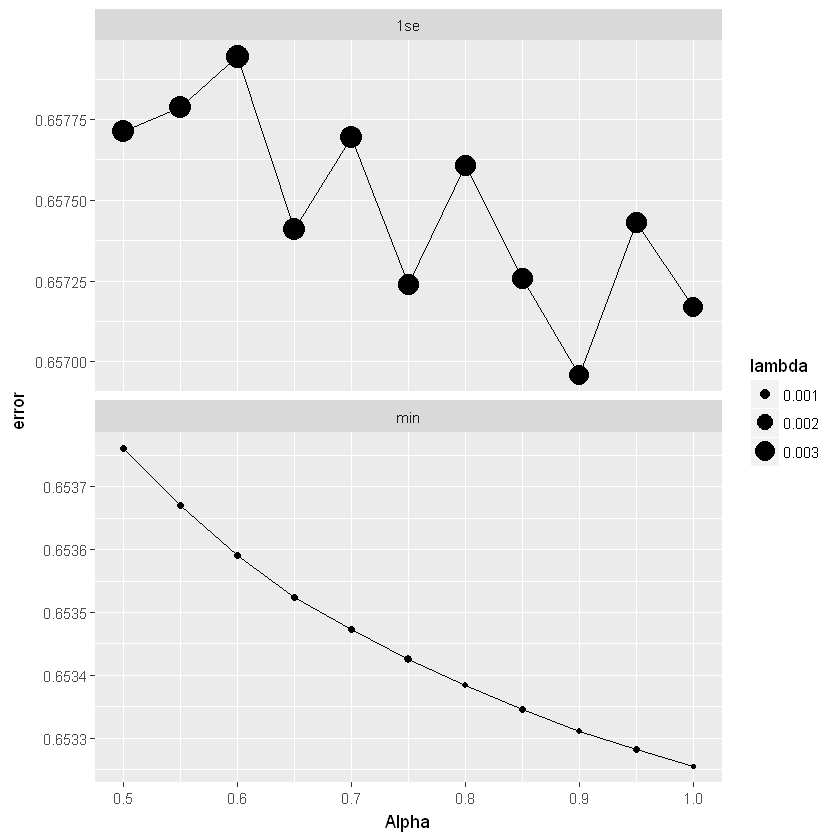

In [160]:
ggplot(alphaCast, aes(x=Alpha, y=error))+
    geom_line(aes(group=Type))+
    facet_wrap(~Type, scales="free_y", ncol=1)+
    geom_point(aes(size=lambda))


Clearly, 0.9 is the optimal value of $\alpha$ since the bottom pane shows the minimum error corresponds to $\alpha$ = 1.0 which is higher with respect to the top pane.

Now, we refit the model with optimal $\alpha$

In [161]:
set.seed(5222841)

In [162]:
adultCV3 <- cv.glmnet(x=adultX, y=adultY, family="binomial", nfold=5, alpha=alphaInfo$Alpha[which.min(alphaInfo$error.1se)])

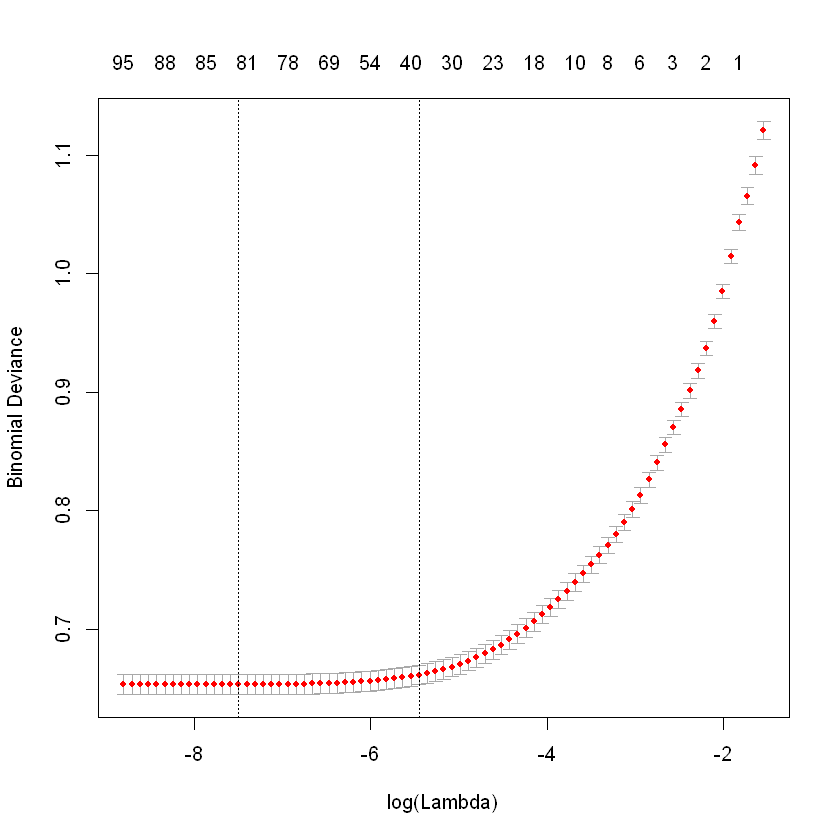

In [163]:
plot(adultCV3)

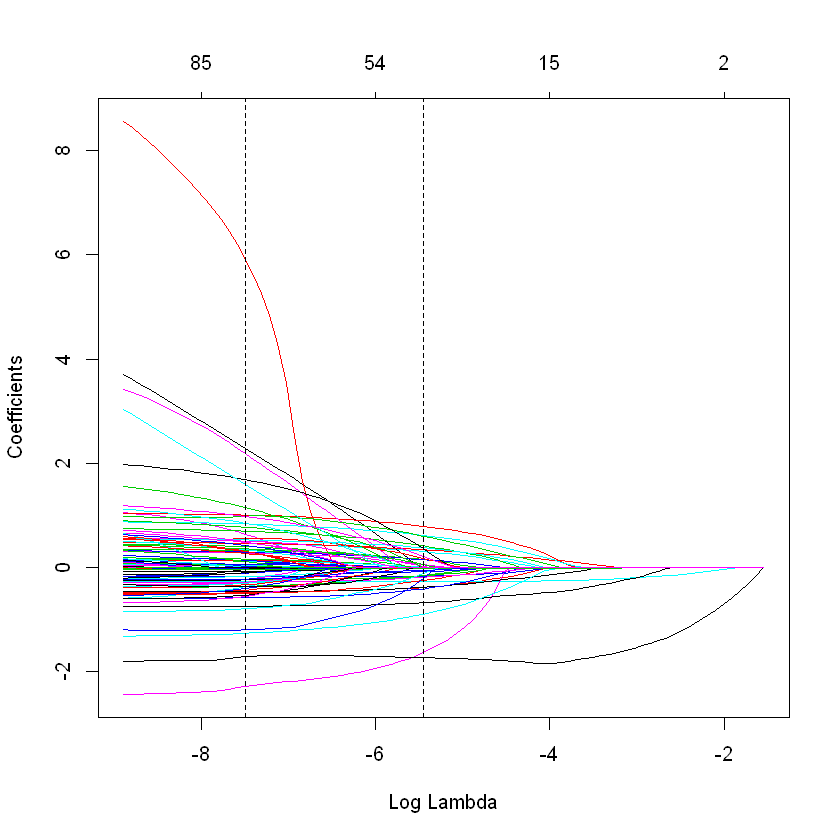

In [164]:
plot(adultCV3$glmnet.fit, xvar="lambda")
abline(v=log(c(adultCV3$lambda.min, adultCV3$lambda.1se)), lty=2)

Next, in the plot to follow, we find that..... wow! Farming-fishing occupation is a strong indicator of income over 50K and so on and so forth.........

In [165]:
theCoef <- as.matrix(coef(adultCV3, s="lambda.1se"))
coefDF <- data.frame(Value=theCoef, Coefficient=rownames(theCoef))
coefDF <- coefDF[nonzeroCoef(coef(adultCV3, s="lambda.1se")), ]

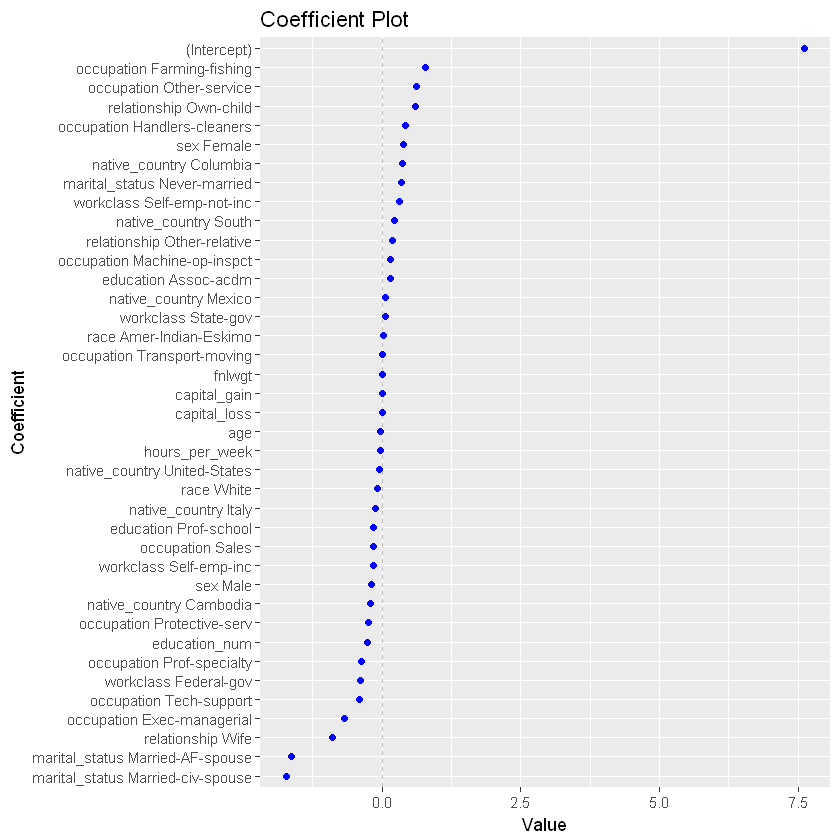

In [166]:
ggplot(coefDF, aes(x=X1, y=reorder(Coefficient, X1))) +
    geom_vline(xintercept = 0, color="grey", linetype=2)+
    geom_point(color="blue")+
    labs(x="Value", y="Coefficient", title="Coefficient Plot")

Hey wait! Can you help me figure out why is the intercept so strong in the plot right above? Your expert comments below. Cheers!